In [212]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Operator, Statevector

import numpy as np

# from qsvt.algorithms import linear_solver
from qsvt.algorithms_beta import linear_solver
import time


# matrix size exponent
N = 6

In [213]:
# # Generate a random circulant matrix.
# np.random.seed(0)
def circulant_matrix(N):
    a = [np.random.random() for _ in range(2 ** N)]
    for i in range(2 ** N):
        k = np.random.random()
        if k > 0.5: 
            a[i] *= -1
    # print(a)

    A = []
    for _ in range(2 ** N):
        A.append(a.copy())
        k = a.pop(0)
        a.append(k)

    A = np.array(A)
    # kappa = np.linalg.cond(A)
    return A

def sparse_matrix(A, d):
    L = len(A)
    zero_num = L - d
    for i in range(L):
        zero_pos = np.random.choice(range(L), zero_num)
        for j in zero_pos:
            A[i, j] = 0
    return A

def gen_random_matrix(kappa_upper, d):
    while True:
        A = circulant_matrix(N)
        d = min(d, 2**N)
        A = sparse_matrix(A, d)

        kappa = np.linalg.cond(A)
        print(f'kappa: {kappa}')
        if kappa <= kappa_upper: 
            return A
        
A = gen_random_matrix(50-1e-9, 2**(N))
print(A)

kappa: 26.38084949858846
[[-0.40454721  0.0039364  -0.56558044 ... -0.46512894 -0.84822043
   0.24282978]
 [ 0.0039364  -0.56558044  0.53847054 ... -0.84822043  0.24282978
  -0.40454721]
 [-0.56558044  0.53847054 -0.44246318 ...  0.24282978 -0.40454721
   0.0039364 ]
 ...
 [-0.46512894 -0.84822043  0.24282978 ... -0.03167909  0.72241155
   0.5106363 ]
 [-0.84822043  0.24282978 -0.40454721 ...  0.72241155  0.5106363
  -0.46512894]
 [ 0.24282978 -0.40454721  0.0039364  ...  0.5106363  -0.46512894
  -0.84822043]]


In [214]:
# 16 * 16
# A = np.[[0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333], [0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133], [0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484], [0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615], [0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227], [0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885], [0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117], [0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631], [0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816], [0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081], [0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739], [0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805], [0.6849054170543225, 0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582], [0.5437824898334759, 0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225], [0.23208190595437173, 0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759], [0.77368360476333, 0.490648203407133, 0.2186134761020484, 0.12664679799037615, 0.20935261189478227, 0.18183374301837885, 0.18596569631386117, 0.5921672771247631, 0.9183885704786816, 0.2765242687174081, 0.6526777537113739, 0.33094133497910805, 0.5486557161590582, 0.6849054170543225, 0.5437824898334759, 0.23208190595437173]])

In [215]:
# A = np.array([
#     [1, -1/3],
#     [-1/3, 1]
# ])

# A = np.array([
#      [1, 2, 3, 4],
#      [4, 1, 2, 3],
#      [3, 4, 1, 2],
#      [2, 3, 4, 1]]
# , dtype=float)

# A = np.array([
#     [1, 2, 3, 4, 5, 6, 7, 8],
#     [2, 3, 4, 5, 6, 7, 8, 1],
#     [3, 4, 5, 6, 7, 8, 1, 2],
#     [4, 5, 6, 7, 8, 1, 2, 3],
#     [5, 6, 7, 8, 1, 2, 3, 4],
#     [6, 7, 8, 1, 2, 3, 4, 5],
#     [7, 8, 1, 2, 3, 4, 5, 6],
#     [8, 1, 2, 3, 4, 5, 6, 7]
# ], dtype=float)


A_norm = np.linalg.norm(A)
# print(f'A norm: {A_norm}')
A /= A_norm

# print(f'A:\n{A}')
kappa = np.linalg.cond(A)
print(f'kappa: {kappa}')

W, S, Vd = np.linalg.svd(A)
# print(f'SVD of normalized A:\n\tW:\n{W}\n\tS:\n{S}\n\tVd:\n{Vd}')

st = time.time()
qc = linear_solver(A)
# qc = linear_solver(A, eps=0.01, set_kappa=True)
# qc = linear_solver(A, set_kappa=True)
# qc = linear_solver(A, set_kappa=True, amplify='AA')
# qc = linear_solver(A, set_kappa=True, amplify='sign')
# qc = linear_solver(A, amplify='sign')
# qc = linear_solver(A, real_only=False)
# qc = linear_solver(A, amplify='chebyshev')
# qc = linear_solver(A, amplify='sign')
# qc = linear_solver(A, amplify='AA')
ed = time.time()
print(f'prepare circuit spends: {ed - st} sec')

# print(f'circuit depth: {qc.depth()}')
# qc.draw('mpl')

kappa: 26.3808494985885
deg: 121
QSVT spends: 0.08469629287719727 sec
prepare circuit spends: 0.08511161804199219 sec


In [216]:
st = time.time()
state = Statevector(qc)
ed = time.time()
print(f'prepare state snapshot spends: {ed - st} sec')

n = qc.num_qubits
print(f'number of qubits: {n}')

# for AA
# measure_qubits = [n - 3, n - 2]
# exp_outcome = "00"

# for no AA
measure_qubits = [n - 2, n - 1]
exp_outcome = "00"

# for no AA and no real_only
# measure_qubits = [n - 1]
# exp_outcome = "0"

st = time.time()
while True:
    outcome, mstate = state.measure(measure_qubits)
    if outcome == exp_outcome: break
ed = time.time()
print(f'post-measurement state: {mstate}')
print(f'post-selection spends: {ed - st} sec')

############## solve by singular values ################
# fS = 1 / S
# print(f'fS: {fS}')

# fAd = np.conj(Vd.T) * fS @ np.conj(W.T) # A^\dagger
# print(f'fAd: {fAd}')


# res = np.array(fAd[:, 0])
########################################################

# # for AA: 3 ancilla qubits
# res = np.linalg.solve(A, np.array([1] + [0] * (2 ** (n - 3) - 1)))

# for no AA: 2 ancilla qubits
res = np.linalg.solve(A, np.array([1] + [0] * (2 ** (n - 2) - 1)))

# for no AA and no real_only: 1 ancilla qubits
# res = np.linalg.solve(A, np.array([1] + [0] * (2 ** (n - 1) - 1)))

res /= np.linalg.norm(res)
print(f'res: {res}')
# print(f'res: {res / np.linalg.norm(res)}')

prepare state snapshot spends: 0.04652237892150879 sec
number of qubits: 8
post-measurement state: Statevector([-1.67925169e-02+1.78626074e-19j,
              4.34447079e-02-1.55850757e-19j,
             -5.52924223e-02-2.83098642e-19j,
             -1.73179435e-01+1.76730921e-18j,
              8.02338102e-02-1.80219204e-20j,
             -1.70099524e-01+7.09832560e-18j,
             -1.57220314e-01+1.71333389e-18j,
              1.90985410e-01+5.33740586e-19j,
             -8.55575522e-02+2.29233232e-18j,
             -1.78503611e-01-1.51721539e-19j,
             -2.39326026e-01+3.25780930e-18j,
             -1.27276928e-01-7.08413291e-20j,
              1.97450154e-02+1.11525184e-17j,
              2.79164612e-02-9.34984085e-20j,
             -1.25119040e-01+2.22499493e-20j,
              2.75105571e-01-2.98013861e-18j,
             -1.53310507e-01-2.92546216e-18j,
             -1.15541663e-02+4.56021416e-19j,
             -1.10066991e-01+4.88886153e-18j,
             -1.62768221e-0

In [217]:
# Calculate total variance
from qsvt.helper import total_variation

P = np.array([mstate[i] for i in range(2 ** N)])
P = np.array([np.linalg.norm(x)**2 for x in P])
print(f'P: {P}')
# res = [-0.63012604,  0.070014,    0.070014,    0.77015405]
Q = np.array([x ** 2 for x in res])
print(f'Q: {Q}')

print(f'kappa: {kappa}')
print(f'total_variation (exact): {total_variation(P, Q)}')

P: [2.81988625e-04 1.88744265e-03 3.05725196e-03 2.99911167e-02
 6.43746431e-03 2.89338480e-02 2.47182272e-02 3.64754270e-02
 7.32009475e-03 3.18635390e-02 5.72769467e-02 1.61994164e-02
 3.89865635e-04 7.79328808e-04 1.56547741e-02 7.56830753e-02
 2.35041115e-02 1.33498759e-04 1.21147424e-02 2.64934939e-02
 4.59507058e-04 8.84680878e-03 2.31315526e-05 7.51434775e-03
 9.82438578e-06 8.85286409e-04 4.87990523e-02 1.88208254e-04
 1.56698070e-02 7.44057451e-06 8.67336417e-03 7.25828605e-03
 1.63726198e-02 2.85508107e-02 6.95387118e-03 2.93734371e-03
 2.34433483e-04 4.32920997e-02 4.54702702e-02 1.12103984e-03
 8.26615126e-04 4.51944725e-02 2.73515528e-03 1.14298508e-03
 7.92225641e-08 1.17812401e-03 7.99492769e-02 8.06994728e-04
 1.38185628e-02 5.72623757e-03 9.62076745e-02 1.39918615e-02
 4.89117209e-05 3.74149382e-03 5.36086114e-04 2.57353564e-02
 3.28058458e-03 3.03601602e-03 1.92185393e-02 1.76733366e-04
 1.10231787e-02 2.66339654e-02 3.55522662e-04 2.17236605e-03]
Q: [1.23304305e-03 5

time: 0.08688950538635254 sec


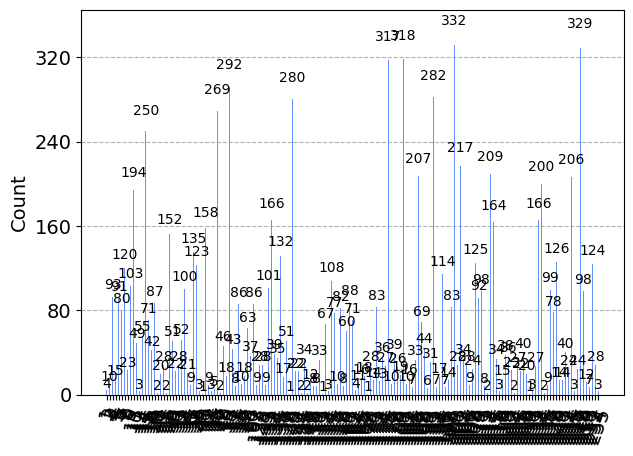

In [218]:
# Use `Statevector()` to run 10000 shots (SLOW!!!)
from qiskit.visualization import plot_histogram

st = time.time()
state = Statevector(qc)
P = np.array([np.linalg.norm(x)**2 for x in state])
shots = 10000
# counts = {}

# print(len(state), len(list(range(2 ** N))))
a = np.random.choice(a=list(range(2 ** n)), p=P, size=shots)
a = np.sort(a)
unique_elements, counts = np.unique(a, return_counts=True)
counts = dict(zip(unique_elements, counts))
# print(a)

# for _ in range(shots):
#     outcome, tmp_state = state.measure(list(range(n)))
#     if counts.get(outcome) == None:
#         counts[outcome] = 0
#     else:
#         counts[outcome] += 1

ed = time.time()
print(f'time: {ed - st} sec')
plot_histogram(counts)

qc depth: 486
transpilation spends: 0.10055899620056152 sec
transpiled qc depth: 727
run job spends: 0.0005023479461669922 sec


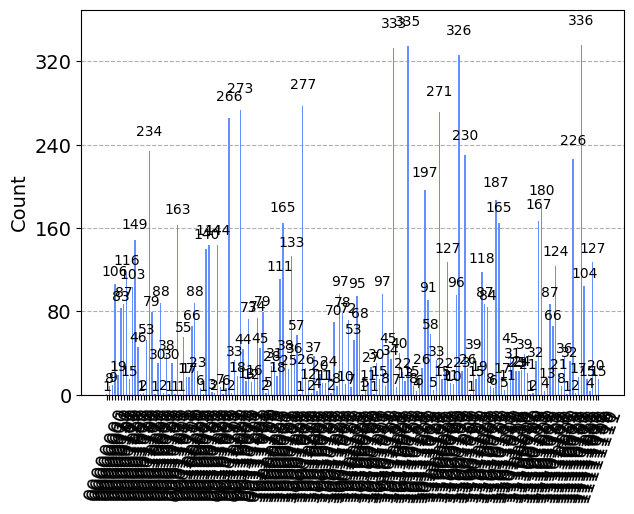

In [219]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# cr = ClassicalRegister(len(measure_qubits))
# qc.add_register(cr)
# qc.measure(measure_qubits, cr)
qc.measure_all()
print(f'qc depth: {qc.depth()}')

# It seems that even if 'GPU' is specified, GPU is not used at all.
# Since QSVT involves large multi-qubit gates (block-encoding), "extended_stabilizer" is not efficient.
# sim = AerSimulator(method='extended_stabilizer')
sim = AerSimulator(method='statevector')
# sim = AerSimulator(method='statevector', device='GPU')

st = time.time()
transpiled_circuit = transpile(qc, sim)
# transpiled_circuit = transpile(qc, sim, optimization_level=3)
ed = time.time()
print(f'transpilation spends: {ed - st} sec')
# transpiled_circuit = transpile(qc, sim, optimization_level=3)
print(f'transpiled qc depth: {transpiled_circuit.depth()}')


# run job
shots = 10000
st = time.time()
job = sim.run(transpiled_circuit, shots=shots, dynamic=True, blocking_enable=True, blocking_qubits=10)
ed = time.time()

print(f'run job spends: {ed - st} sec')
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
plot_histogram(exp_counts)

In [220]:
# Calculate total variance
from qsvt.helper import total_variation

# experiment count
# print(f'exp_counts: {exp_counts}')
valid_count = np.zeros(shape=(2 ** N))
for data in exp_counts:
    # print(f'data: {data[:]}')
    if data[:2] == '00':
        # print(int(data[2:], base=2))
        valid_count[int(data[2:], base=2)] = exp_counts[data]
valid_count /= shots
valid_count /= np.linalg.norm(valid_count)
# print(f'valid_count: {valid_count}')

Q = np.array([x ** 2 for x in res])
print(f'Q: {Q}')

print(f'kappa: {kappa}')
print(f'total_variation (exp): {total_variation(valid_count, Q)}')

Q: [1.23304305e-03 5.20953728e-03 7.86055049e-04 5.83912458e-02
 2.04716942e-02 1.89844221e-02 2.63433107e-02 2.44313830e-02
 2.77404563e-02 6.58878800e-07 8.60394389e-02 1.06831089e-03
 6.88515660e-04 5.45167580e-03 1.29188851e-04 1.30741809e-03
 7.68123345e-04 1.57873472e-02 5.93719058e-03 2.14693105e-03
 1.09153792e-02 1.77569393e-02 1.86863604e-02 6.80977915e-03
 1.66378972e-03 1.31058900e-03 4.42360097e-02 7.26445792e-03
 3.53731720e-02 1.18723729e-02 1.99595154e-02 7.26817182e-04
 1.57447635e-02 1.21093555e-04 7.72309038e-04 3.41243551e-02
 5.99416867e-03 3.27764185e-02 4.42799313e-02 4.86844962e-03
 1.01787164e-02 4.65678359e-02 1.56850062e-02 3.70239477e-03
 2.89933022e-04 1.34909874e-02 1.16084689e-02 1.68128683e-02
 2.48705898e-02 6.21024231e-03 2.88139028e-02 2.85183987e-04
 7.35400827e-03 1.37173620e-02 1.63727721e-02 4.35292095e-02
 4.36680446e-03 5.81354088e-03 2.79002131e-02 8.71712941e-03
 2.69078397e-02 4.17619344e-02 6.86641763e-03 4.02106221e-06]
kappa: 26.3808494985

In [221]:
# # Sampler  (slow and "quasi")
# from qiskit.circuit.random import random_circuit 
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler 

# service = QiskitRuntimeService() 

# # Run on a simulator
# backend = service.get_backend("ibmq_qasm_simulator")
# # Or use the next line if you want to run on a system instead of a simulator:
# # backend = service.least_busy(simulator=False)

# # circuit = random_circuit(2, 2, seed=1234) 
# # circuit.measure_all() 

# sampler = Sampler(backend) 
# job = sampler.run(qc) 
# result = job.result() 

# print(qc) 
# print(f" > Quasi probability distribution: {result.quasi_dists}") 
# print(f" > Metadata: {result.metadata}") 



In [222]:
# # remote backend
# from qiskit_ibm_provider import IBMProvider

# hub="ibm-q"; group="open"; project="main"

# # token = 'dc8930d1f18fc7649c1b976a87c9d7f7cf49c1a2db48bcbd34e30245c4e492faafe52f974835e4a6122c03f14b4db02ce2fab9a87b35dc8ebaca2fb408e6aa1a'
# # IBMProvider.save_account(token)

# provider = IBMProvider()
# # This doesn't work
# # backend_name = "simulator_extended_stabilizer" 
# backend_name = "simulator_statevector"
# # backend_name = "ibm_perth"
# provider_backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")
# print(provider_backend.name)

In [223]:
# # run job remotely
# shots = 10000
# st = time.time()
# transpiled_circuit = transpile(qc, provider_backend)
# # transpiled_circuit = transpile(qc, provider_backend, optimization_level=3)
# ed = time.time()
# print(f'transpilation spends: {ed - st} sec')
# print(f'transpiled qc depth: {transpiled_circuit.depth()}')

# # job = provider_backend.run(transpiled_circuit, shots=shots)
# job = provider_backend.run(qc, shots=shots)

# print('job submitted!')

# # Get the results and display them
# exp_result = job.result()
# exp_counts = exp_result.get_counts()
# plot_histogram(exp_counts)

In [224]:
# # Run on AWS Braket (error)
# from qiskit_braket_provider import AWSBraketProvider

# provider = AWSBraketProvider()

# # devices
# device = provider.get_backend("Lucy")
# print(device)

# task = device.run(qc, shots=100)

# arn = task.job_id()
# retrieved = device.retrieve_job(job_id=arn)

# print(retrieved.status())

In [225]:
# plot_histogram(retrieved_job.result().get_counts())

In [226]:
# # basis gates
# aer_config = sim.configuration()
# aer_basis_gates = aer_config.basis_gates
# print(len(aer_basis_gates))

# config = provider_backend.configuration()
# basis_gates = config.basis_gates
# print(len(basis_gates))

# aer_basis_gates.sort()
# basis_gates.sort()
# print(aer_basis_gates)
# print(basis_gates)

# for gate in basis_gates:
#     if gate not in aer_basis_gates:
#         print(f'{gate} not in aerSim')
# for gate in aer_basis_gates:
#     if gate not in basis_gates:
#         print(f'"{gate}" not in Sim')